# Medical Insurance Cost

**Dataset:** [Kaggle Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance/data)\
**Auhtor:** Dmitry Luchkin\
**Date:** 2025-02-09

## Goals

The primary objective of this project is to compare the performance of several regression models and determine which one provides the most accurate predictions for medical insurance costs. The evaluation will be based on the following performance metrics:

- **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in the predictions.
- **Mean Squared Error (MSE)**: Highlights the average of the squares of the errors, giving more weight to large errors.
- **R² Score**: Indicates the proportion of variance in the target variable that is explained by the model.

The regression models to be evaluated in this project include:

- **Multiple Linear Regression**: A foundational model that assumes a linear relationship between features and the target variable.
- **Ridge and Lasso Regression**: Regularized linear models that help prevent overfitting by adding penalty terms to the loss function.
- **Polynomial Regression**: A form of linear regression that allows for capturing non-linear relationships between features and the target.
- **Support Vector Regression (SVR)**: A non-linear regression model that uses a kernel trick to find the optimal hyperplane that best fits the data.
- **Decision Tree Regressor**: A tree-based model that splits the data into distinct regions to make predictions.
- **Random Forest Regressor**: An ensemble model that combines multiple decision trees to improve accuracy and reduce overfitting.

## Dataset

The dataset contains information about medical insurance costs based on several demographic and health-related factors. The target variable is `charges`, representing the total medical expenses billed to an individual.

The dataset includes the following features:

+ `age` (integer) – Age of the individual
+ `sex` (categorical: male/female) – Gender of the individual
+ `bmi` (float) – Body Mass Index, a measure of body fat based on height and weight
+ `children` (integer) – Number of dependent children covered by the insurance
+ `smoker` (categorical: yes/no) – Whether the individual is a smoker
+ `region` (categorical: 4 unique values) – Geographic region of the individual
+ `charges` (float, target variable) – Total medical insurance cost billed

The dataset includes both numerical and categorical features, requiring appropriate preprocessing before training regression models.

In [ ]:
# Libraries loading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import zscore

from scipy.stats import probplot

%matplotlib inline
sns.set_theme(style="ticks", palette="pastel")

In [1]:
# Data Loading 
data = pd.read_csv('./00_data/insurance.csv')

## Exploratory Data Analysis

To better understand the dataset, we analyze its descriptive statistics and generate visualizations.

+ Target: `charges`
+ Features:
    + `age`
    + `sex`
    + `bmi`
    + `children`
    + `smoker`
    + `region`

### Summary statistics

In [2]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# summary statistics
data.select_dtypes(include=np.number).describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### `age` variable

In [6]:
print(sorted(data['age'].unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]


### `sex` variable

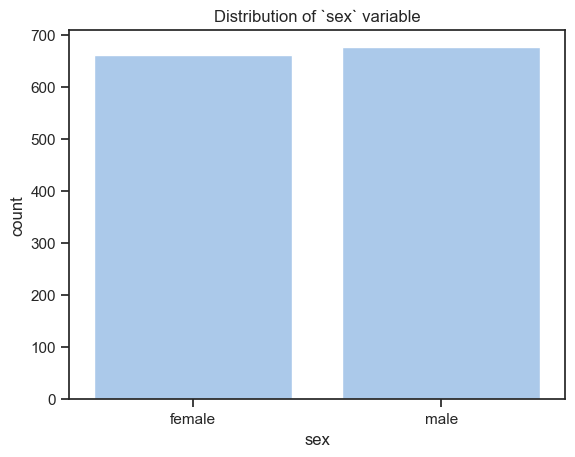

In [7]:
sns.countplot(data, x='sex')
plt.title('Distribution of `sex` variable')
plt.show()

### `smoker` variable

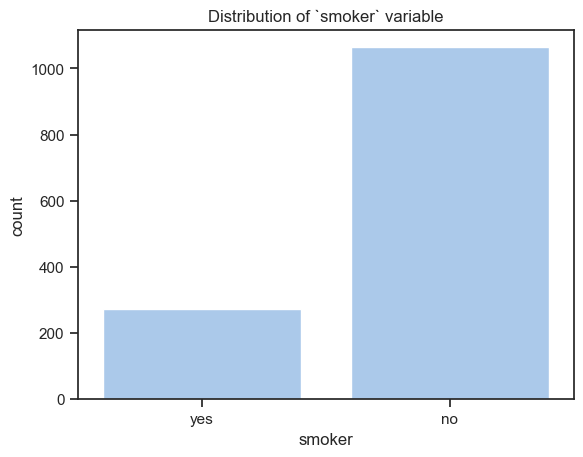

In [8]:
sns.countplot(data, x='smoker')
ax = plt.title('Distribution of `smoker` variable')
plt.show()

### `children` variable

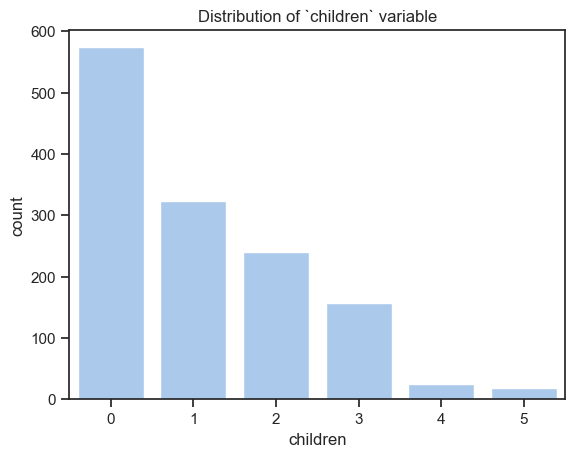

In [9]:
sns.countplot(data, x='children')
plt.title('Distribution of `children` variable')
plt.show()

### `region` variable

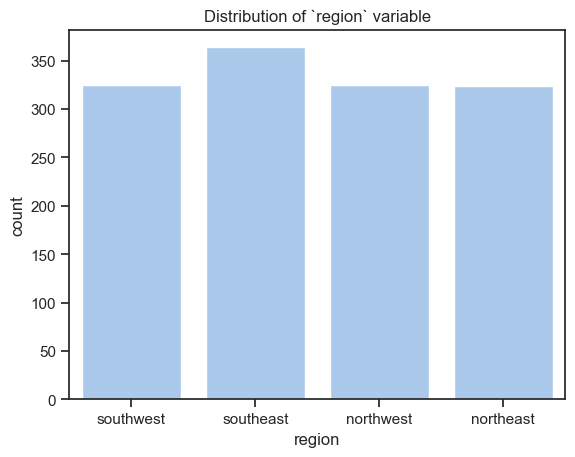

In [10]:
sns.countplot(data, x='region')
plt.title('Distribution of `region` variable')
plt.show()

### `bmi` variable

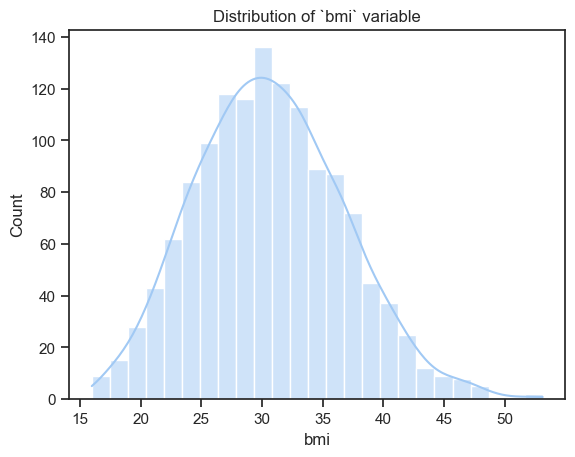

In [11]:
sns.histplot(data, x='bmi', kde=True)
plt.title('Distribution of `bmi` variable')
plt.show()

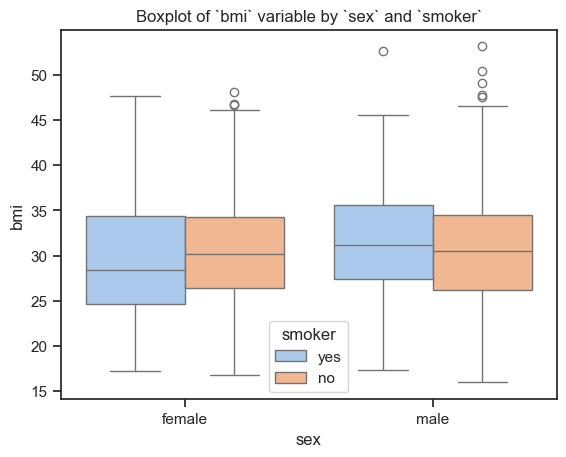

In [12]:
sns.boxplot(data, x = 'sex', y = 'bmi', hue='smoker')
plt.title('Boxplot of `bmi` variable by `sex` and `smoker`')
plt.show()

In [13]:
# possible bmi outliers

z_scores = zscore(data['bmi'])
data[(z_scores < -3) | (z_scores > 3)]

,age,sex,bmi,children,smoker,region,charges
116,58,male,49.06,0,no,southeast,11381.3254
847,23,male,50.38,1,no,southeast,2438.0552
1047,22,male,52.58,1,yes,southeast,44501.3982
1317,18,male,53.13,0,no,southeast,1163.4627


There are no outliers by `bmi` variable.

MBI classification due to WHO recommendations:


| BMI Range   | Category             |
|------------|----------------------|
| < 18.5     | Underweight          |
| 18.5 – 24.9 | Normal weight       |
| 25 – 29.9  | Overweight           |
| 30 – 34.9  | Obesity Class 1      |
| 35 – 39.9  | Obesity Class 2      |
| 40+        | Obesity Class 3      |


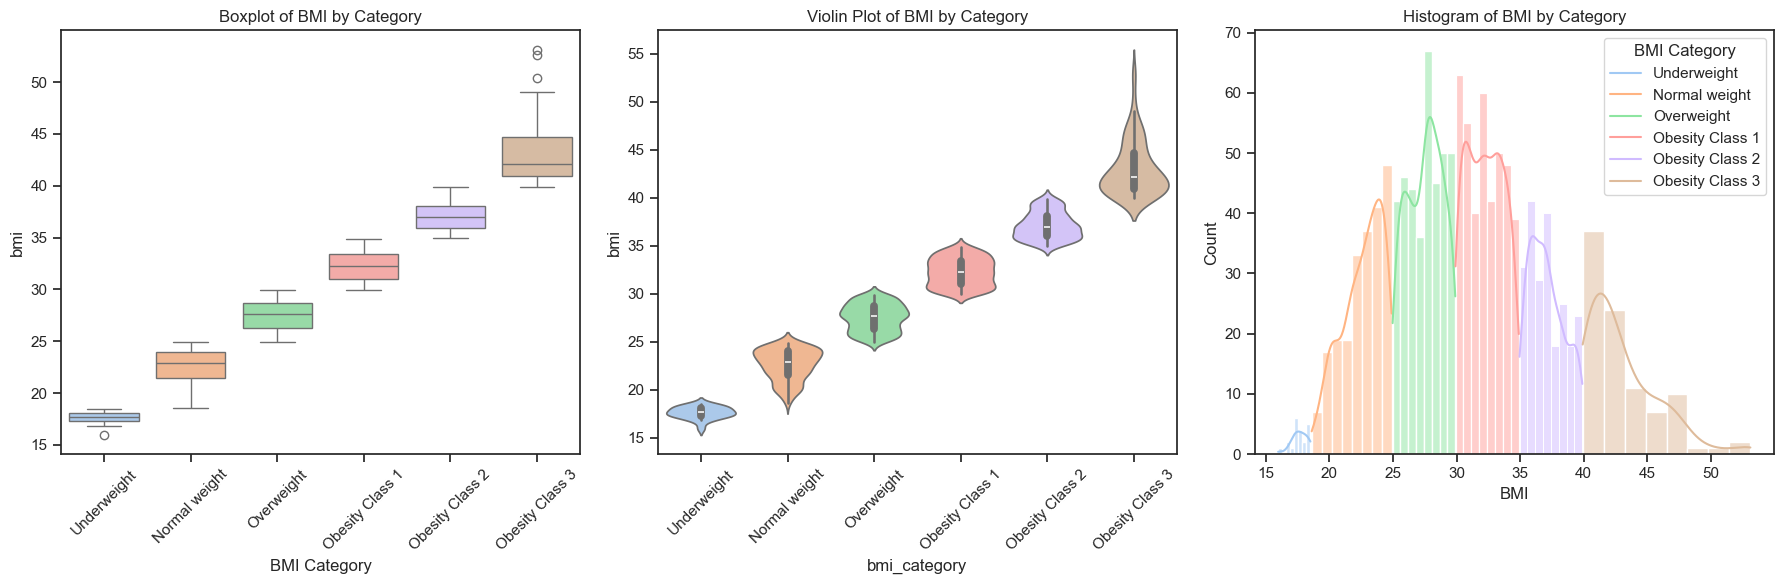

In [14]:
bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]
bmi_labels = ['Underweight', 'Normal weight', 'Overweight', 'Obesity Class 1', 'Obesity Class 2', 'Obesity Class 3']
data['bmi_category'] = pd.cut(data['bmi'], bins=bmi_bins, labels=bmi_labels, right=True)

# Split data by BMI categories
grouped_data = data.groupby('bmi_category', observed=True)
# 3 plots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot
sns.boxplot(x='bmi_category', y='bmi', data=data, ax=axes[0], hue='bmi_category', palette='pastel')
axes[0].set_title('Boxplot of BMI by Category')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('BMI Category')

# Violin plot
sns.violinplot(x='bmi_category', y='bmi', data=data, ax=axes[1], hue='bmi_category', palette='pastel')
axes[1].set_title('Violin Plot of BMI by Category')
axes[1].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('BMI Category')

# Histogram for each BMI category
colors = sns.color_palette('pastel', n_colors=len(bmi_labels))
for category, color in zip(bmi_labels, colors):
    sns.histplot(data[data['bmi_category'] == category]['bmi'], kde=True, bins=8, label=category, ax=axes[2],
                color=color)
axes[2].set_title('Histogram of BMI by Category')
axes[2].set_xlabel('BMI')

#axes[2].legend()
axes[2].legend(title='BMI Category', labels=bmi_labels)

plt.tight_layout()
plt.show()

### `charges` variable

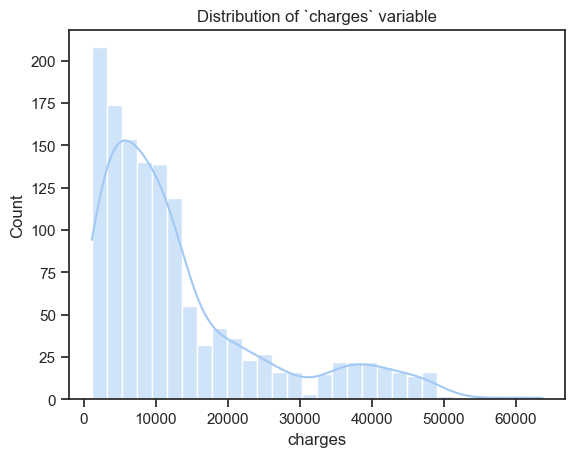

In [15]:
sns.histplot(data, x='charges', kde=True)
plt.title('Distribution of `charges` variable')
plt.show()

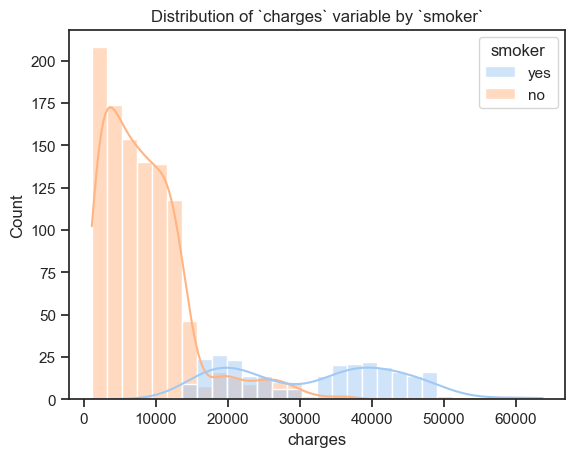

In [16]:
sns.histplot(data, x='charges', kde=True, hue='smoker')
plt.title('Distribution of `charges` variable by `smoker`')
plt.show()

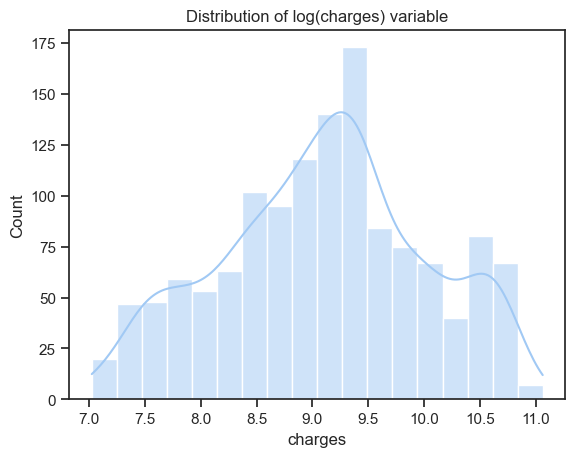

In [17]:
sns.histplot(x=np.log(data['charges']), kde=True)
plt.title('Distribution of log(charges) variable')
plt.show()

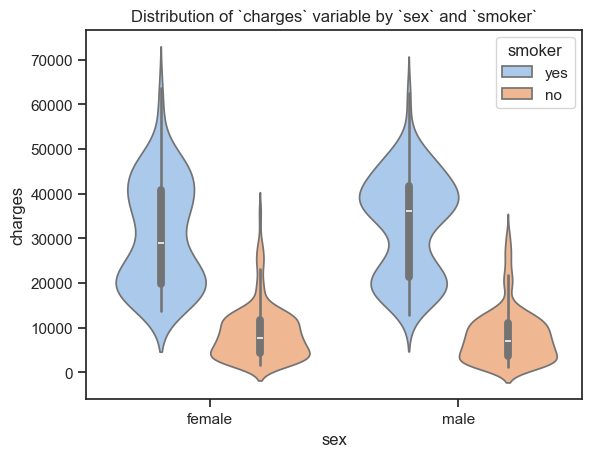

In [18]:
sns.violinplot(data, x='sex', y='charges', hue = 'smoker')
plt.title('Distribution of `charges` variable by `sex` and `smoker`')
plt.show()

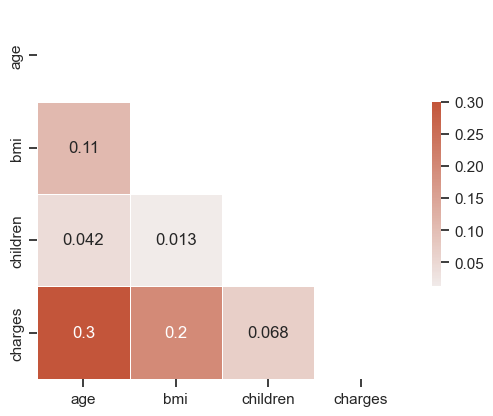

In [19]:
corr = data.select_dtypes(include=np.number).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

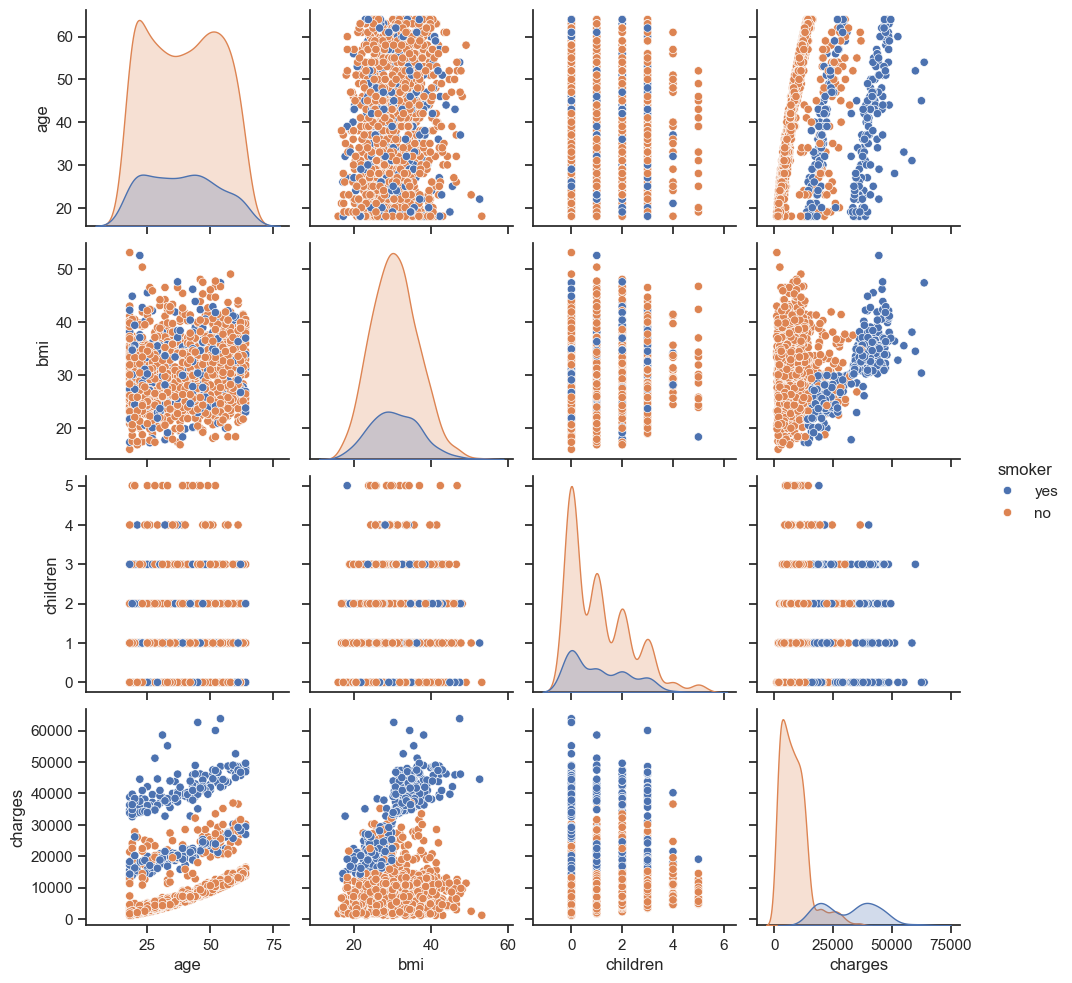

In [20]:
sns.set_theme(style="ticks")
sns.pairplot(data, hue="smoker")
plt.show()

In [21]:
# possible charges outliers

z_scores = zscore(data['charges'])
data[(z_scores < -3) | (z_scores > 3)]

,age,sex,bmi,children,smoker,region,charges,bmi_category
34,28,male,36.400,1,yes,southwest,51194.55914,Obesity Class 2
543,54,female,47.410,0,yes,southeast,63770.42801,Obesity Class 3
577,31,female,38.095,1,yes,northeast,58571.07448,Obesity Class 2
819,33,female,35.530,0,yes,northwest,55135.40209,Obesity Class 2
1146,60,male,32.800,0,yes,southwest,52590.82939,Obesity Class 1
1230,52,male,34.485,3,yes,northwest,60021.39897,Obesity Class 1
1300,45,male,30.360,0,yes,southeast,62592.87309,Obesity Class 1


### Missing values

In [22]:
data.isnull().sum()

age             0
sex             0
bmi             0
children        0
smoker          0
region          0
charges         0
bmi_category    0
dtype: int64

### Duplicates

In [23]:
data.duplicated().sum()

1

### Key Data Insights

+ There are **no** missing values and only **one** duplicate.
+ **`age`**:
  + The mean age in the dataset is **39 years**.
  + It is necessary to apply **standard scaling** to this variable.

+ **`sex`**:
  + The genders are represented in an **almost 50/50 proportion**.
  + This variable needs to be **converted into a numeric format**.

+ **`bmi`**:
  + The variable follows a **normal distribution** and has **four potential outliers** based on the **3σ-rule**.
  + It is necessary to apply **standard scaling** to this variable.

+ **`children`**:
  + It is necessary to apply **standard scaling** to this variable.

+ **`smoker`**:
  + The number of **non-smokers** is **three times greater** than the number of smokers.
  + The variance of the **charges** variable depends on **smoker status**.
  + This variable needs to be **converted into a numeric format**.

+ **`region`**:
  + The dataset includes **four regions**, all of which have **similar proportions**.
  + It is necessary to apply **one-hot encoding** to this variable to create **dummy variables**.

+ **`charges`**:
  + The variable has a **right-skewed distribution**.
  + We will fit models for both the **target variable** and its **log transformation**.
  + There is a **possible non-linear relationship** between `charges` and the **`age`** and **`bmi`** variables.


## Data preprocessing

### Drop duplicates

In [24]:
data.shape

(1338, 8)

In [25]:
# drop fully duplicates
data.drop_duplicates(inplace=True)

In [26]:
data.duplicated().sum()

0

### Features encoding

In [27]:
# encode smoker
data['smoker_encoded'] = data['smoker'].map({'yes': 1, 'no': 0})
# encode sex
data['sex_encoded'] = data['sex'].map({'female': 1, 'male': 0})

In [28]:
# encode region
# drop first to avoid multicollinearity
encoder = OneHotEncoder(sparse_output=False, dtype=int, drop='first')
regions = np.array(encoder.fit_transform(data[['region']]))
column_names = encoder.get_feature_names_out(['region'])
data[column_names] = regions
data.head()

,age,sex,bmi,children,smoker,region,charges,bmi_category,smoker_encoded,sex_encoded,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,Overweight,1,1,0,0,1
1,18,male,33.770,1,no,southeast,1725.55230,Obesity Class 1,0,0,0,1,0
2,28,male,33.000,3,no,southeast,4449.46200,Obesity Class 1,0,0,0,1,0
3,33,male,22.705,0,no,northwest,21984.47061,Normal weight,0,0,1,0,0
4,32,male,28.880,0,no,northwest,3866.85520,Overweight,0,0,1,0,0


In [29]:
# select features for fitting the models
data = data.loc[:, ['age', 'sex_encoded', 'smoker_encoded', 'bmi', 'children', 'region_northwest', 'region_southeast',
        'region_southwest',  'charges']]
data.rename(columns={'sex_encoded': 'sex',
                     'smoker_encoded': 'smoker'}, inplace=True)
data.head()

,age,sex,smoker,bmi,children,region_northwest,region_southeast,region_southwest,charges
0,19,1,1,27.900,0,0,0,1,16884.92400
1,18,0,0,33.770,1,0,1,0,1725.55230
2,28,0,0,33.000,3,0,1,0,4449.46200
3,33,0,0,22.705,0,1,0,0,21984.47061
4,32,0,0,28.880,0,1,0,0,3866.85520


In [30]:
data.shape

(1337, 9)

In [31]:
X = data.iloc[:, 0:-1]
y = data.iloc[:, -1]

## Models Evaluation

In [32]:
class ModelEvaluator:
    """
    A wrapper class to handle machine learning model training, testing, and evaluation.
    """
    
    def __init__(self, model, name, scale_columns=None):
        """
        Initializes the ModelEvaluator with a given model and preprocessing pipeline.
        
        Parameters:
        model: object
            A scikit-learn compatible machine learning model.
        scale_columns: list, optional
            List of column names to apply standard scaling.
        """
        self.scale_columns = scale_columns
        self.model = model
        self.pipeline = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.model_name = name
    
    def split_data(self, X, y, test_size=0.2, random_state=42):
        """
        Splits the dataset into training and testing sets.
        
        Parameters:
        X: DataFrame
            Feature matrix.
        y: Series
            Target variable.
        test_size: float, optional (default=0.2)
            The proportion of the dataset to include in the test split.
        random_state: int, optional (default=42)
            Random seed for reproducibility.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, 
                                                                               test_size=test_size, 
                                                                               random_state=random_state)
    
    def create_pipeline(self):
        """
        Creates a preprocessing pipeline with standard scaling for selected columns.
        """
        if self.scale_columns is None:
            raise ValueError("No columns specified for scaling.")
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), self.scale_columns)
            ],
            remainder='passthrough'
        )
        
        self.pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', self.model)
        ])
    
    def train(self):
        """
        Trains the model using the training data.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been split. Call split_data() first.")
        
        if self.pipeline is None:
            self.create_pipeline()

        # Set output to pandas DataFrame
        self.pipeline.set_output(transform="pandas")

        self.pipeline.fit(self.X_train, self.y_train)
    
    def evaluate(self):
        """
        Evaluates the model on the test set and returns performance metrics.
        
        Returns:
        dict: Dictionary containing R², MAE, and MSE scores.
        """
        if self.X_test is None or self.y_test is None:
            raise ValueError("Data has not been split. Call split_data() first.")
        
        self.y_pred = self.pipeline.predict(self.X_test)
        
        metrics = {
            "Model": self.model_name,
            "R² Score": r2_score(self.y_test, self.y_pred),
            "Mean Absolute Error (MAE)": mean_absolute_error(self.y_test, self.y_pred),
            "Mean Squared Error (MSE)": mean_squared_error(self.y_test, self.y_pred)
        }
        
        for key, value in metrics.items():
            print(f"{key}: {value}")
        
        return metrics

    def plot_evaluation(self):
        """
        Displays a 2x2 matrix of evaluation plots:
        
        - Predicted vs Actual Plot: Shows how well the model's predictions align with actual values.
        - Residuals Histogram: Displays the distribution of residuals to check for normality.
        - Predicted vs Residuals: Helps identify patterns in prediction errors.
        - Q-Q Plot of Residuals: Assesses normality of residuals by comparing quantiles.
        """
        if self.X_test is None or self.y_test is None:
            raise ValueError("Data has not been split. Call split_data() first.")
        
        residuals = self.y_test - self.y_pred
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Predicted vs Actual
        sns.scatterplot(x=self.y_test, y=self.y_pred, ax=axes[0, 0])
        axes[0, 0].plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'r--')
        axes[0, 0].set_title("Predicted vs Actual")
        axes[0, 0].set_xlabel("Actual Values")
        axes[0, 0].set_ylabel("Predicted Values")
        
        # Histogram of Residuals
        sns.histplot(residuals, kde=True, ax=axes[0, 1])
        axes[0, 1].axvline(0, color='red', linestyle='dashed')
        axes[0, 1].set_title("Distribution of Residuals")
        
        # Predicted vs Residuals
        sns.scatterplot(x=self.y_pred, y=residuals, ax=axes[1, 0])
        axes[1, 0].axhline(0, color='red', linestyle='dashed')
        axes[1, 0].set_title("Predicted vs Residuals")
        axes[1, 0].set_xlabel("Predicted Values")
        axes[1, 0].set_ylabel("Residuals")
        
        # Q-Q Plot of Residuals
        probplot(residuals, dist="norm", plot=axes[1, 1])
        axes[1, 1].set_title("Q-Q Plot of Residuals")
        
        plt.tight_layout()
        plt.show()
        

In [33]:
# global random
random_state = 42

In [34]:
model_metrics = []
model_metrics_log = []

### Linear Regression (pure target variable)

Model: Linear Regression
R² Score: 0.7724363518631284
Mean Absolute Error (MAE): 4181.815956942307
Mean Squared Error (MSE): 38940169.92282634


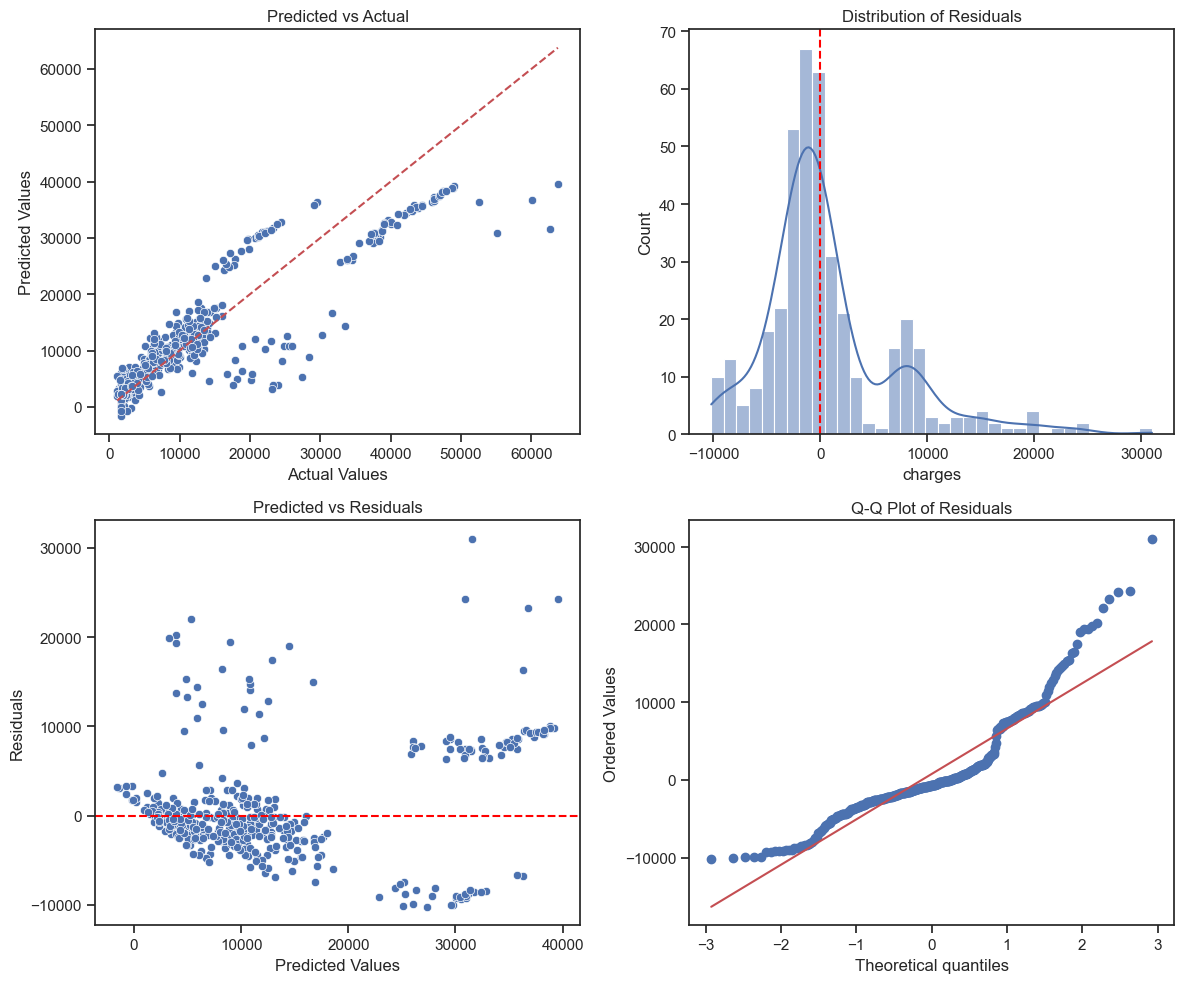

In [35]:
# Linear Regression

scale_columns = ['age', 'children', 'bmi']

evaluator = ModelEvaluator(LinearRegression(), "Linear Regression", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

### Linear Regression (log target variable)

Model: Linear Regression
R² Score: 0.7911164599189274
Mean Absolute Error (MAE): 0.26558126180619823
Mean Squared Error (MSE): 0.18379762468833627


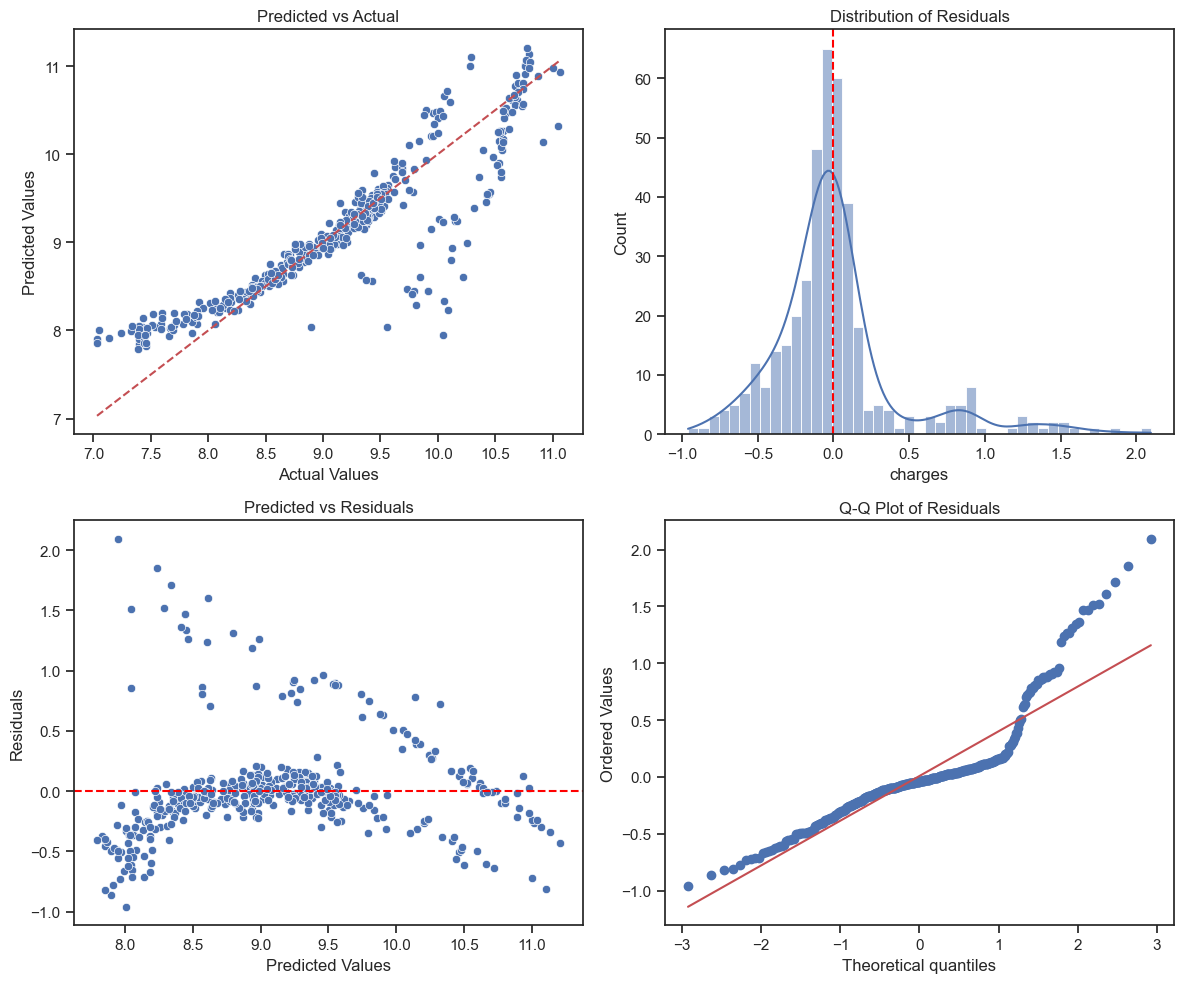

In [36]:
# train linear regression with log(y)
evaluator = ModelEvaluator(LinearRegression(), "Linear Regression", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

### Linear Regression with Regularization

#### Ridge

Model: Ridge
R² Score: 0.7714633689414042
Mean Absolute Error (MAE): 4196.790773808447
Mean Squared Error (MSE): 39106664.53044118


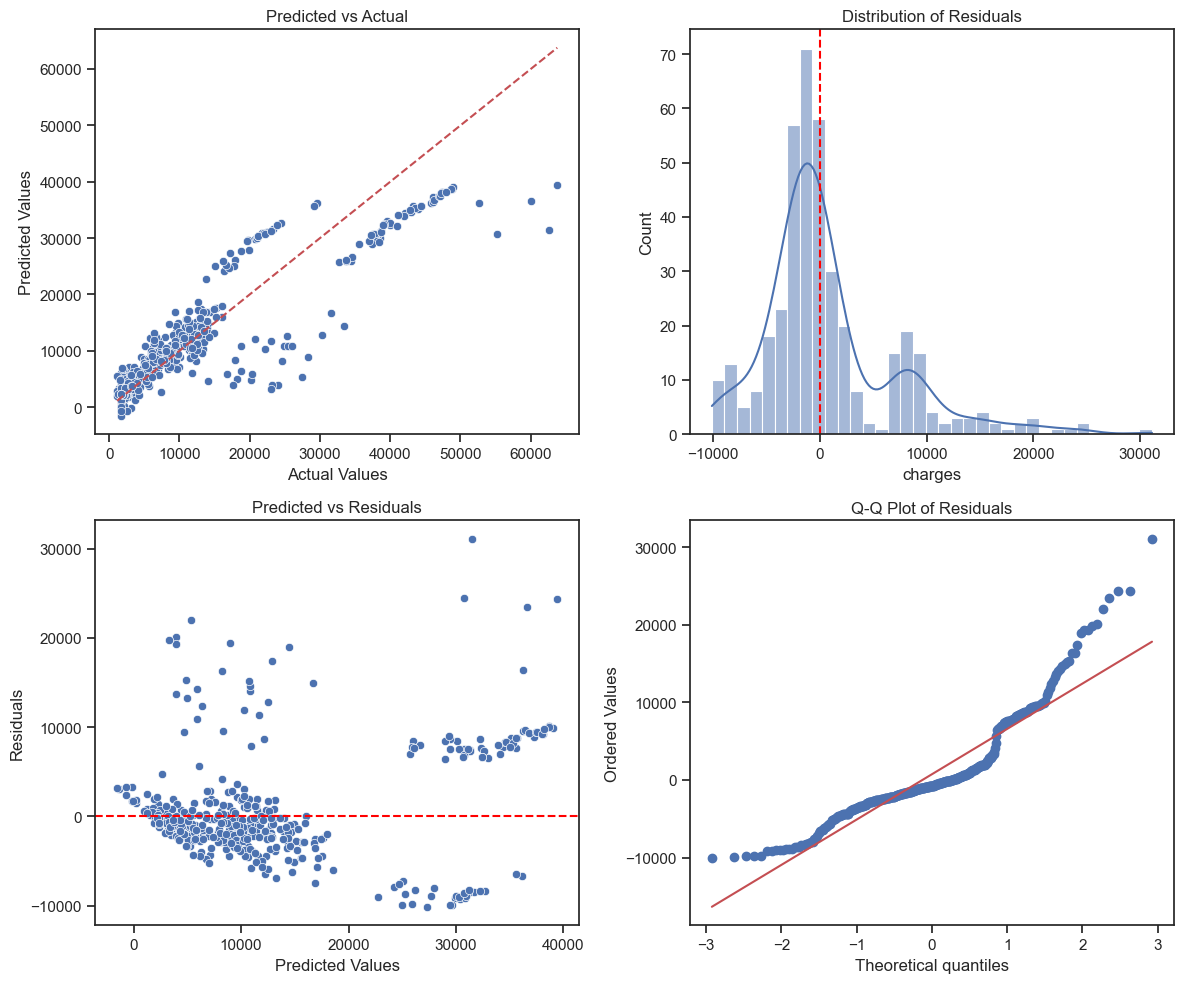

In [37]:
# train linear regression with L2 regularization
evaluator = ModelEvaluator(Ridge(alpha=1.0), "Ridge", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

Model: Ridge
R² Score: 0.7908861557248497
Mean Absolute Error (MAE): 0.26610186047610157
Mean Squared Error (MSE): 0.18400027044879605


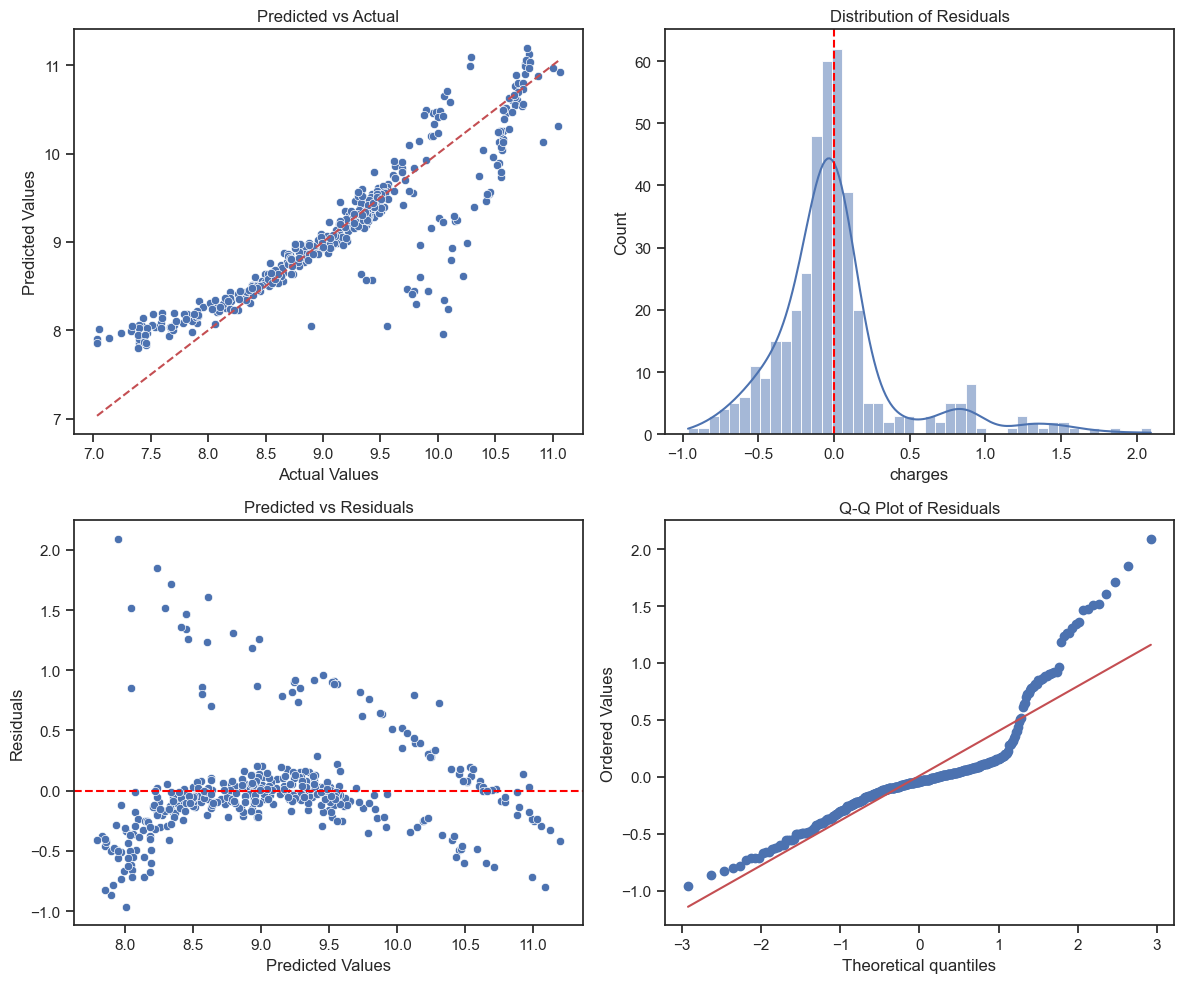

In [38]:
# train linear regression with L2 regularization with log(y)
evaluator = ModelEvaluator(Ridge(alpha=1.0), "Ridge", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

#### Lasso

Model: Lasso
R² Score: 0.7724358414328136
Mean Absolute Error (MAE): 4181.818123519036
Mean Squared Error (MSE): 38940257.26649198


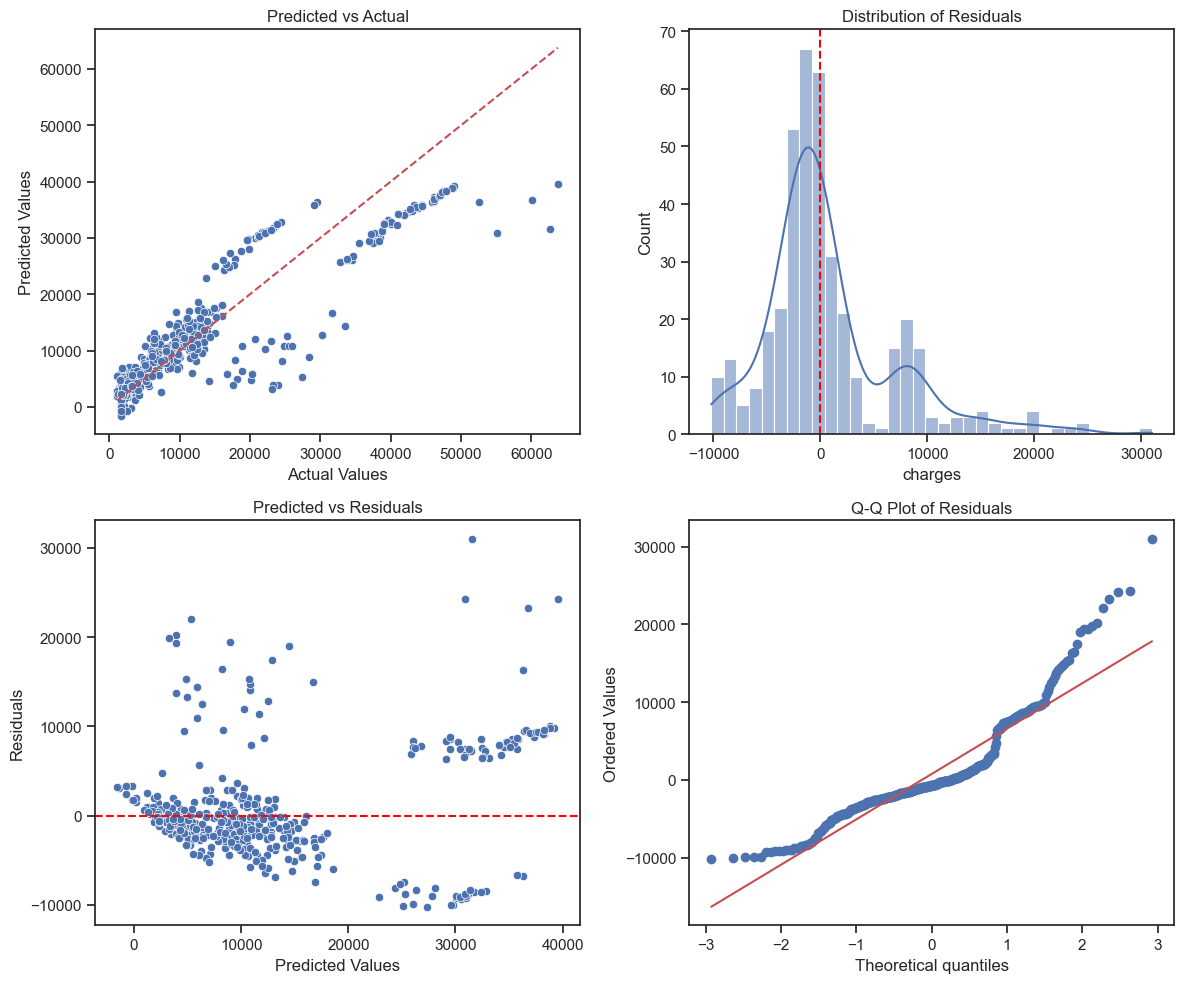

In [39]:
# train linear regression with L1 regularization
evaluator = ModelEvaluator(Lasso(alpha=0.01), "Lasso", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

Model: Lasso
R² Score: 0.7816716632306295
Mean Absolute Error (MAE): 0.27166491140248833
Mean Squared Error (MSE): 0.19210814640919396


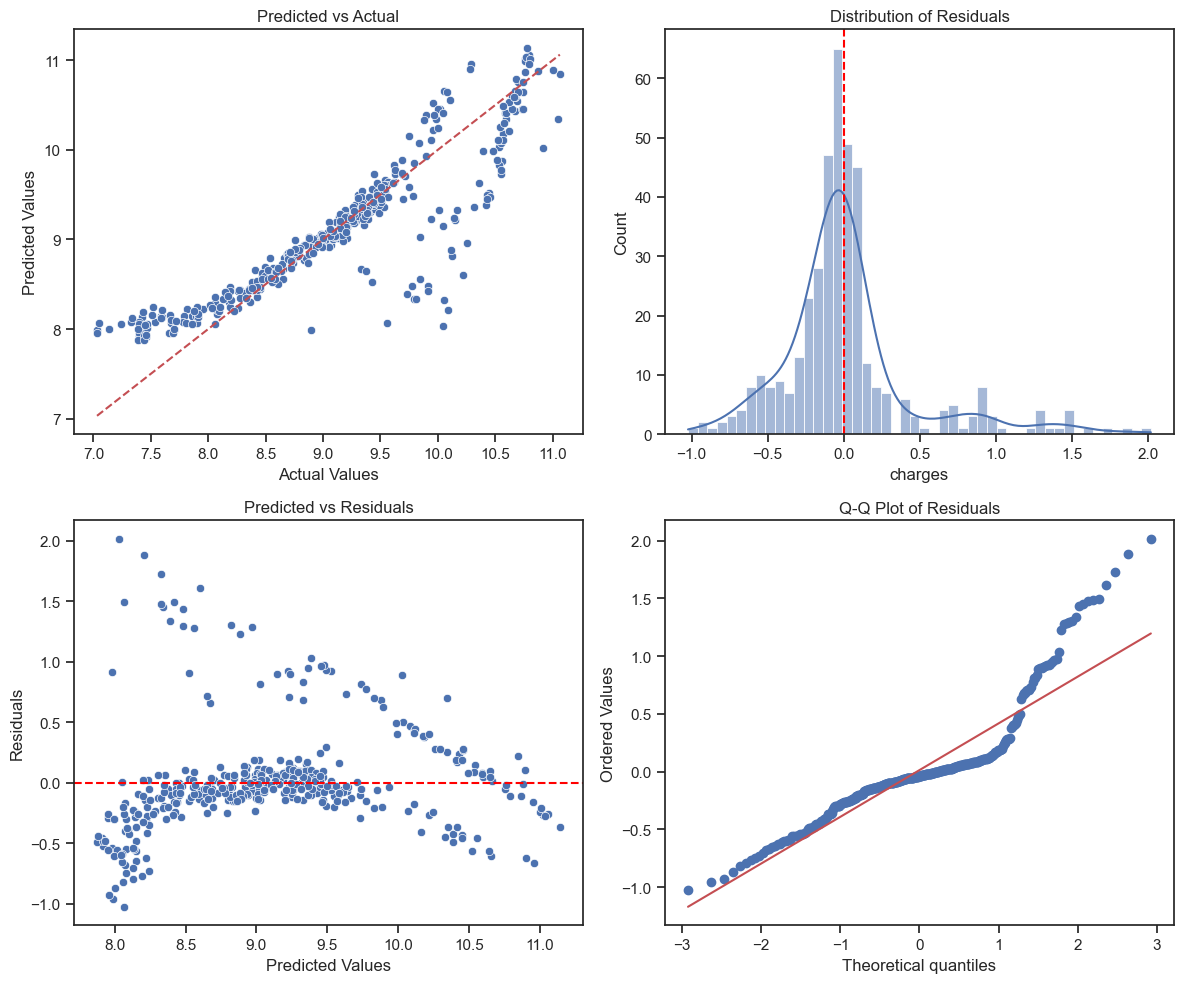

In [40]:
# train linear regression with L1 regularization with log(y)
evaluator = ModelEvaluator(Lasso(alpha=0.01), "Lasso", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

### Support Vector Regression (SVR)

Model: SVR
R² Score: -0.10512067084000276
Mean Absolute Error (MAE): 8556.497770687094
Mean Squared Error (MSE): 189105716.40095323


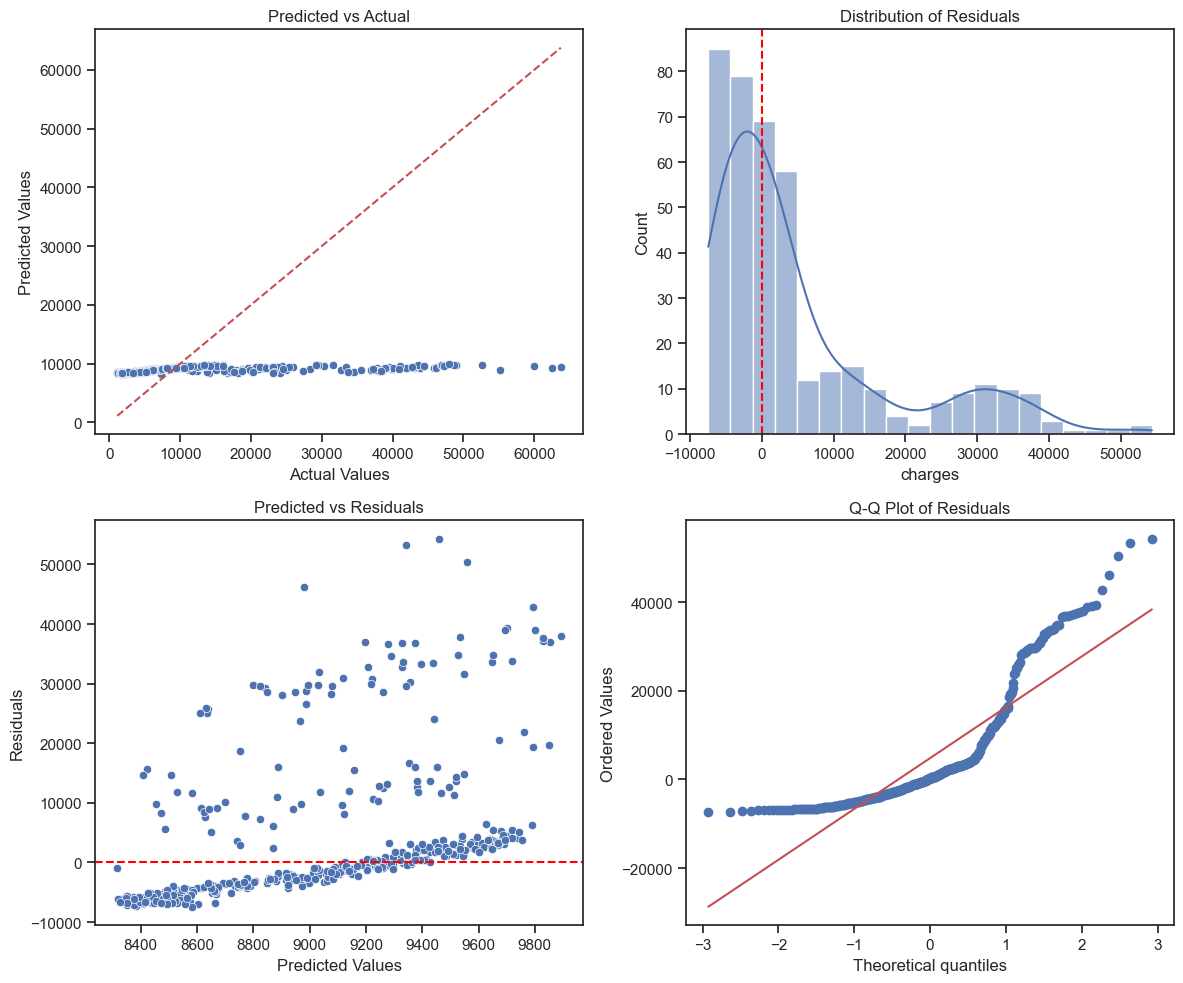

In [41]:
# SVR with pure y
evaluator = ModelEvaluator(SVR(C=10, gamma=0.1, kernel='rbf'), "SVR", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

Model: SVR
R² Score: 0.8452493227953792
Mean Absolute Error (MAE): 0.16801295296376004
Mean Squared Error (MSE): 0.13616586006767906


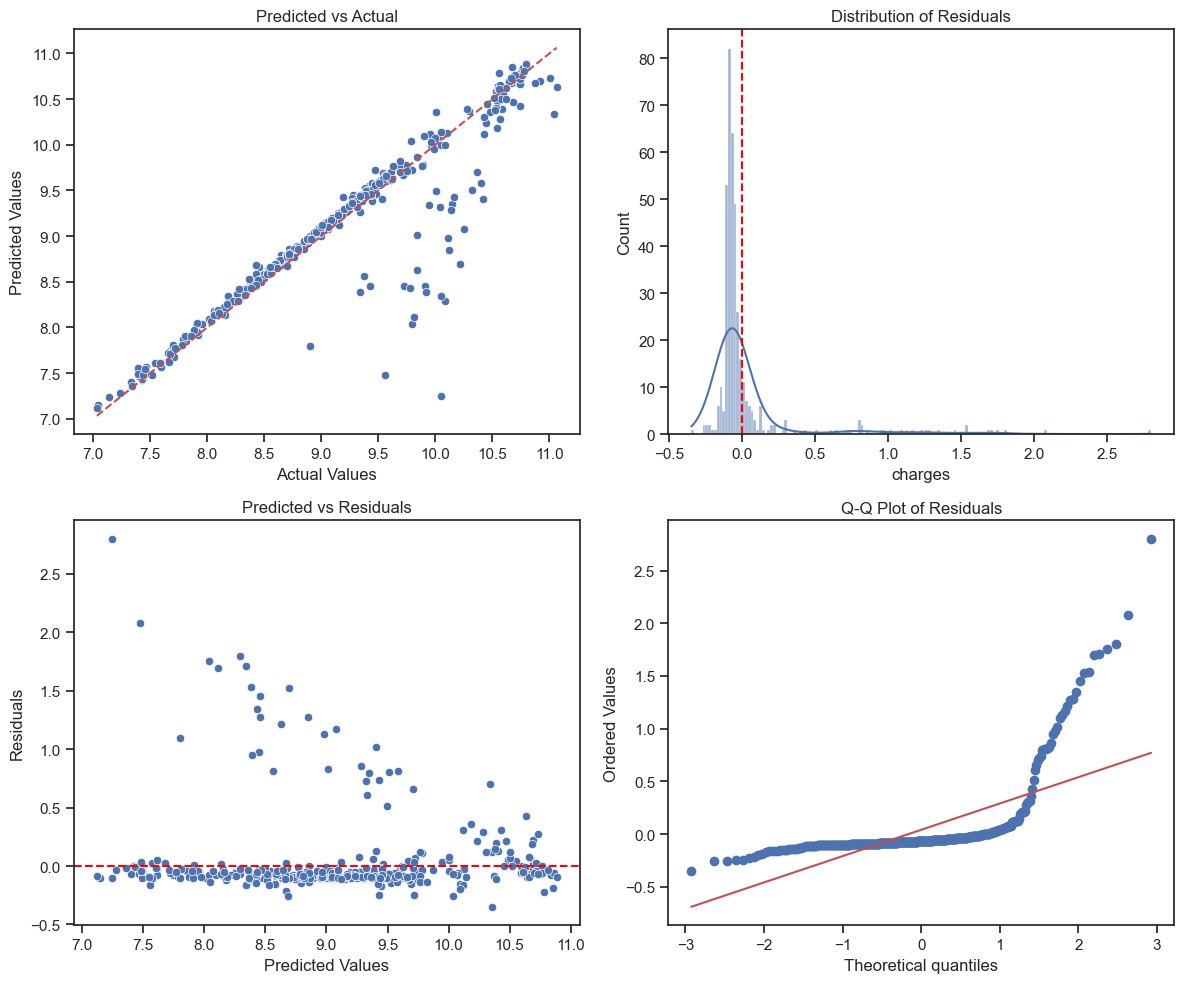

In [42]:
# SVR with log(y)
evaluator = ModelEvaluator(SVR(C=10, gamma=0.1, kernel='rbf'), "SVR", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

### Random Forest Regression

Model: Random Forest
R² Score: 0.8057697095094604
Mean Absolute Error (MAE): 3558.138449976926
Mean Squared Error (MSE): 33236242.15811674


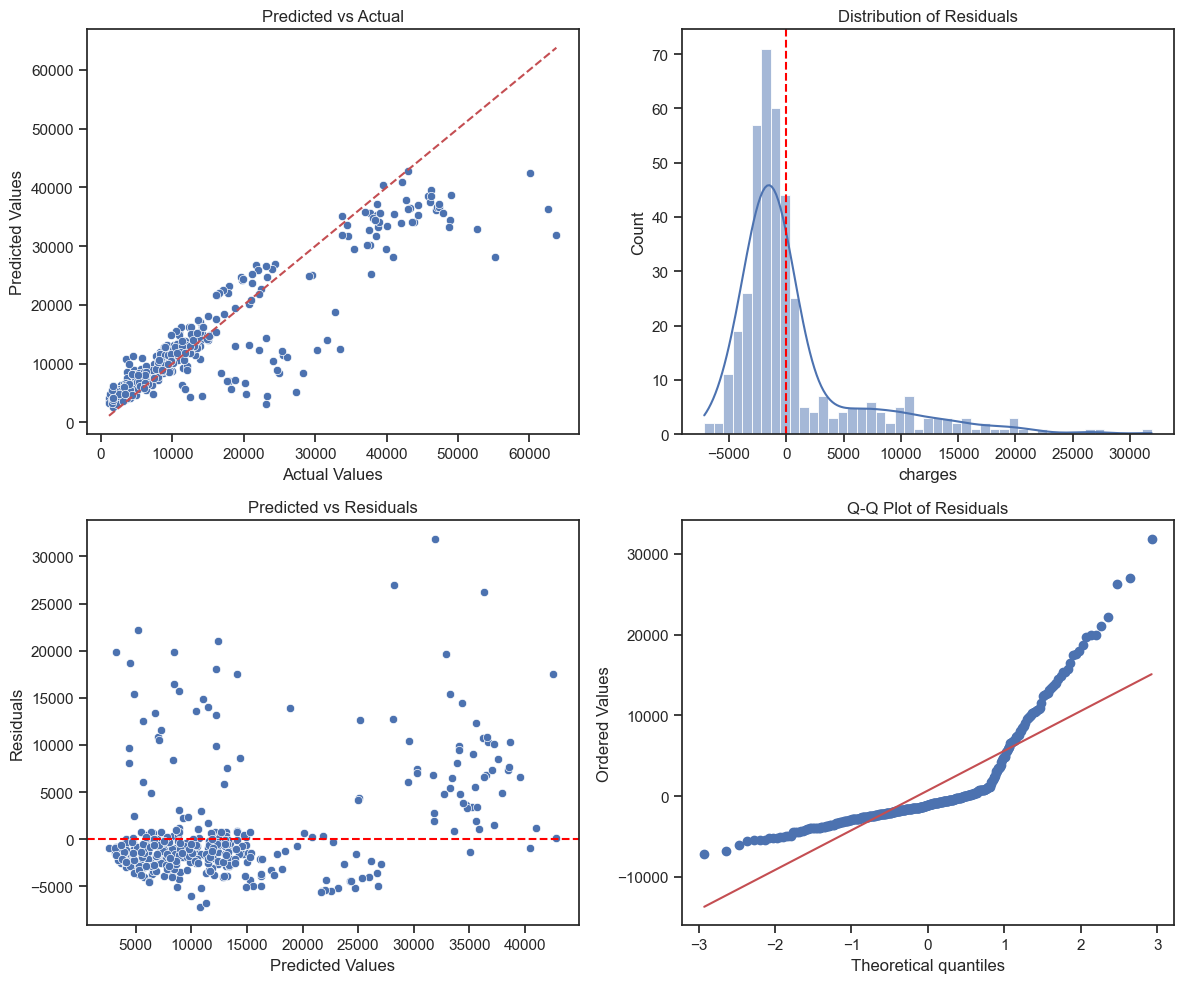

In [43]:
model = RandomForestRegressor(n_estimators=10, max_depth=10, 
                              max_features="sqrt", min_samples_split=10, 
                              min_samples_leaf=4,
                              random_state=42)
evaluator = ModelEvaluator(model, "Random Forest", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

Model: Random Forest
R² Score: 0.8027245775697738
Mean Absolute Error (MAE): 0.211876483750432
Mean Squared Error (MSE): 0.17358358651902794


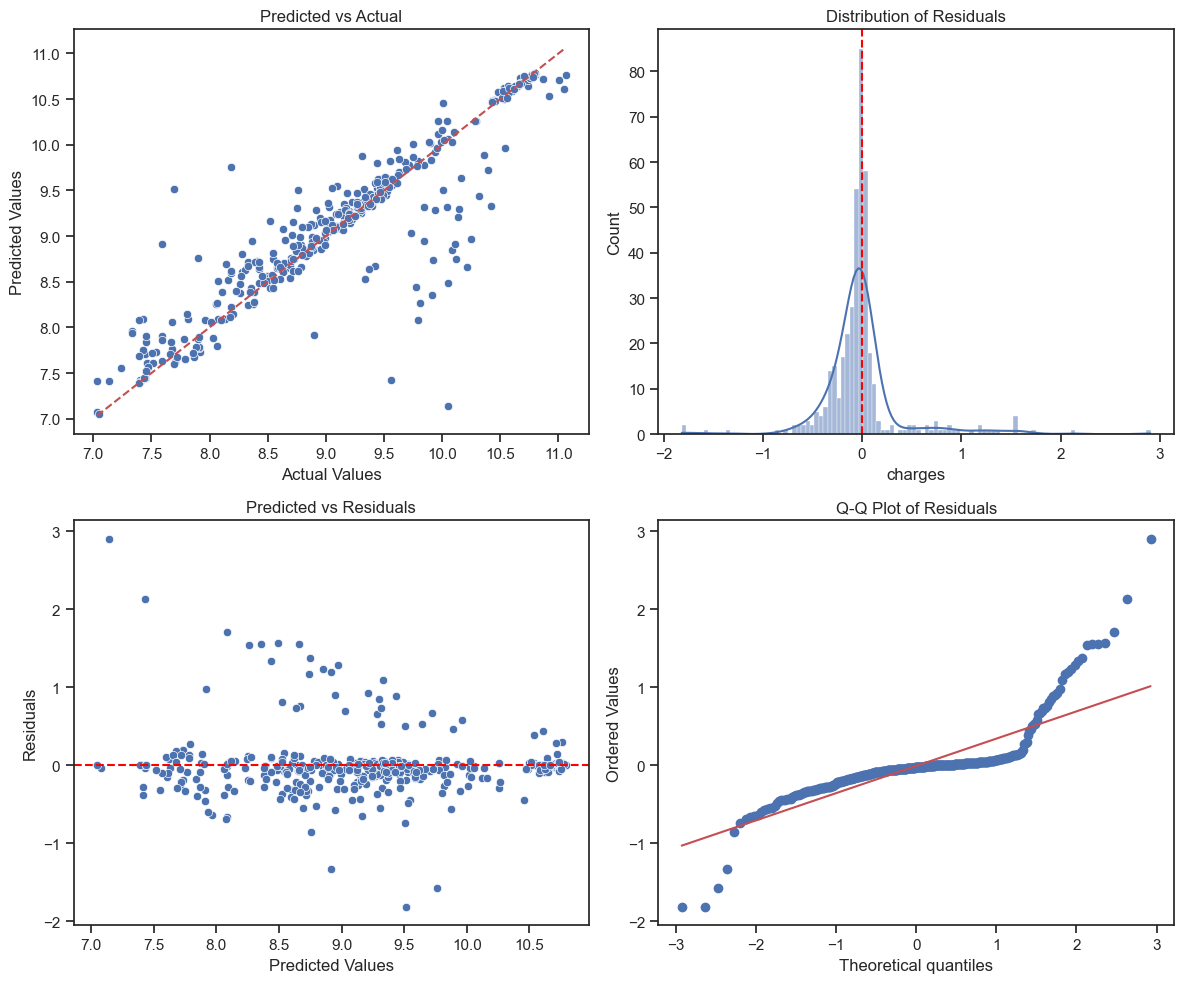

In [44]:
model = RandomForestRegressor(n_estimators=10,
                              random_state=42)
evaluator = ModelEvaluator(model, "Random Forest", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

### Polynomial Regression

Model: Polynomial Regression
R² Score: 0.8507765663512182
Mean Absolute Error (MAE): 2940.8234347289667
Mean Squared Error (MSE): 25534771.96523137


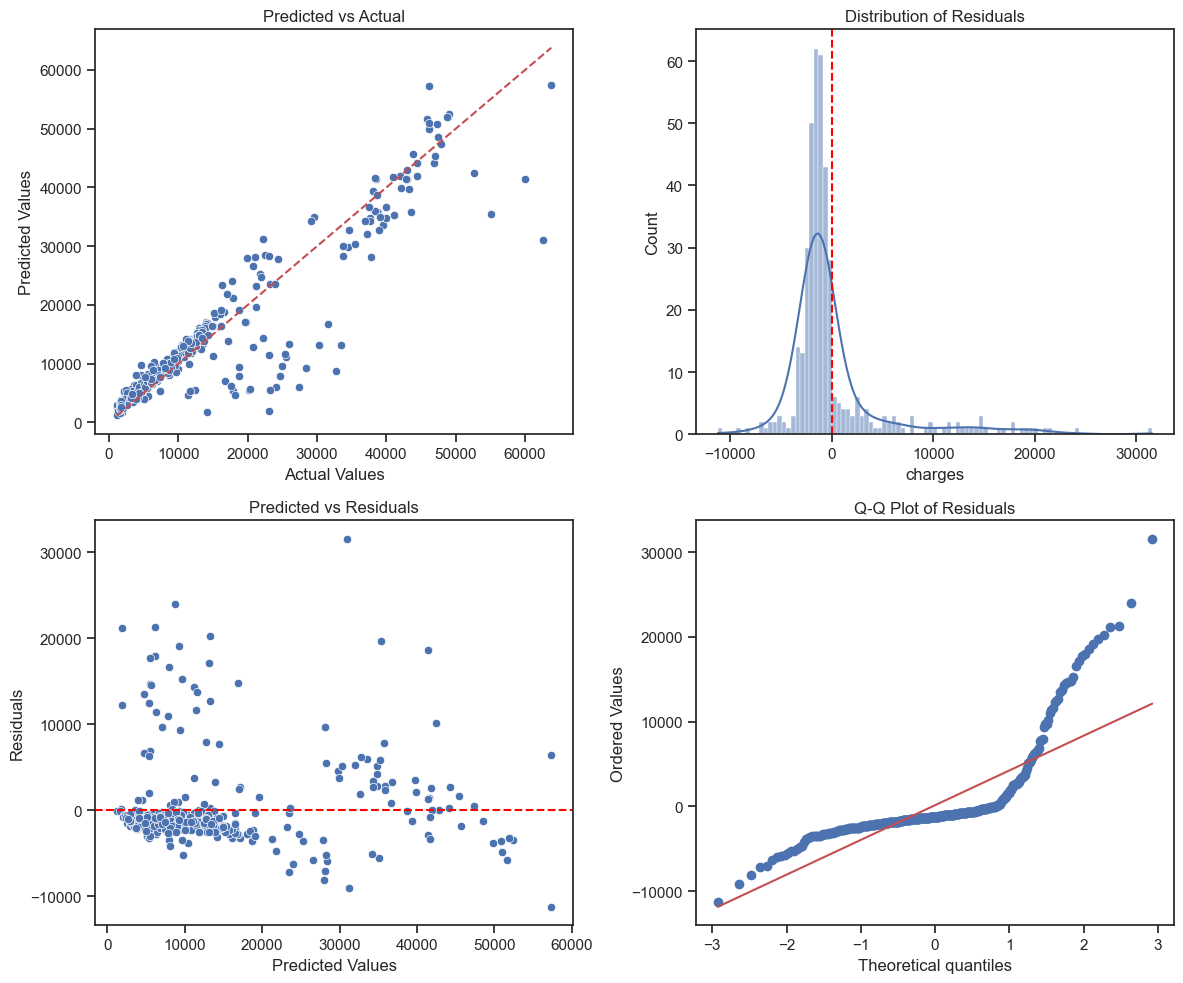

In [45]:
pipe = Pipeline(steps=[
    ('poli', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])
evaluator = ModelEvaluator(pipe, "Polynomial Regression", scale_columns=scale_columns)
evaluator.split_data(X, y, test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics.append(metrics)
evaluator.plot_evaluation()

Model: Polynomial Regression
R² Score: 0.8436888677176378
Mean Absolute Error (MAE): 0.20743905232921214
Mean Squared Error (MSE): 0.13753891194438703


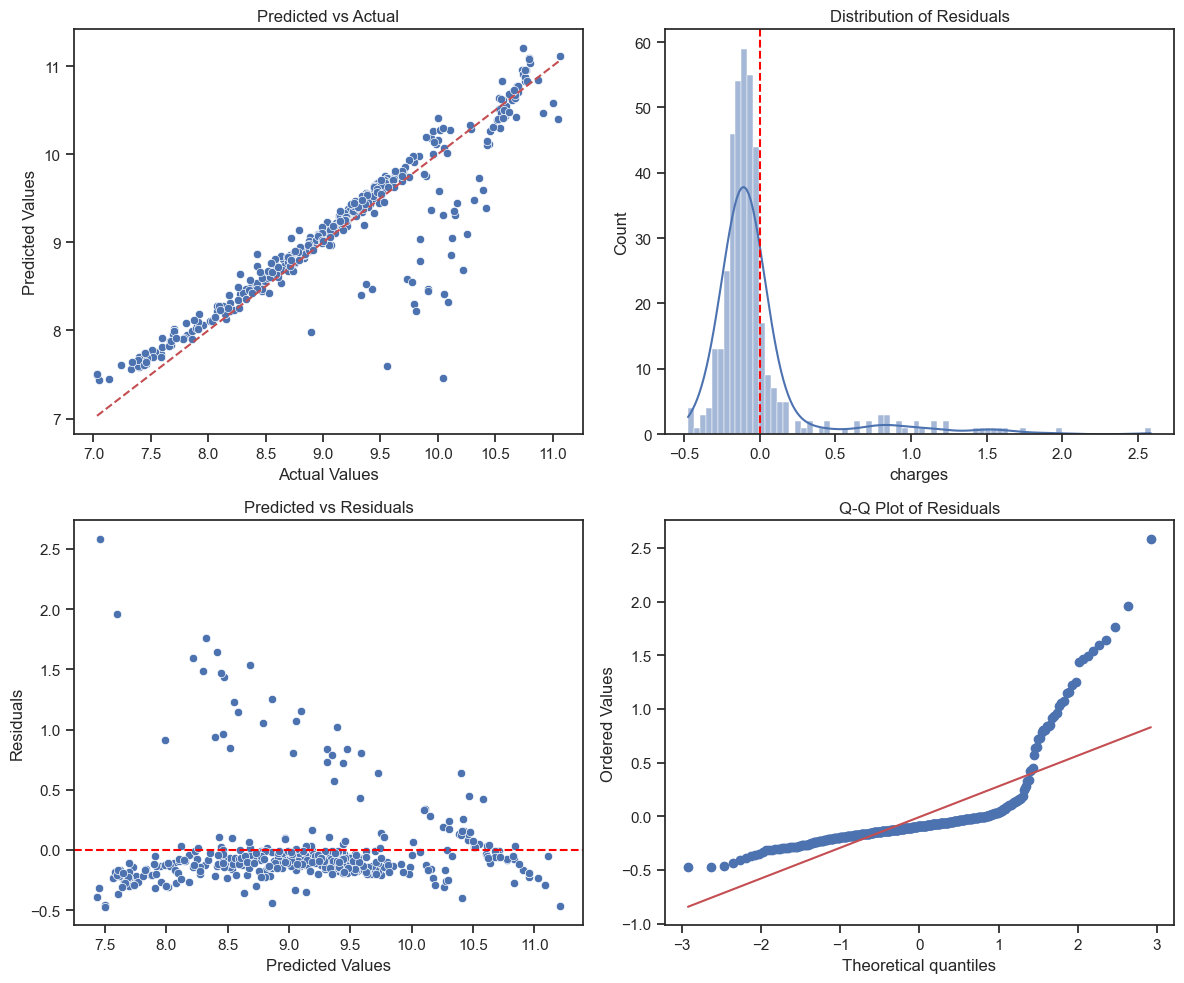

In [46]:
pipe = Pipeline(steps=[
    ('poli', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
])
evaluator = ModelEvaluator(pipe, "Polynomial Regression", scale_columns=scale_columns)
evaluator.split_data(X, np.log(y), test_size=0.3, random_state=random_state)
evaluator.train()
metrics = evaluator.evaluate()
model_metrics_log.append(metrics)
evaluator.plot_evaluation()

## The Best Model Selection

In [47]:
# select the best on target variable 
pd.DataFrame(model_metrics).sort_values(by="R² Score", ascending=False)

,Model,R² Score,Mean Absolute Error (MAE),Mean Squared Error (MSE)
5,Polynomial Regression,0.850777,2940.823435,2.553477e+07
4,Random Forest,0.805770,3558.138450,3.323624e+07
0,Linear Regression,0.772436,4181.815957,3.894017e+07
2,Lasso,0.772436,4181.818124,3.894026e+07
1,Ridge,0.771463,4196.790774,3.910666e+07
3,SVR,-0.105121,8556.497771,1.891057e+08


**Conclusion:**
  
  + Polynomial Regression is the best-performing model in terms of both the R² score and prediction accuracy (MAE and MSE).
  + Random Forest also provides strong performance but slightly worse than Polynomial Regression.
  + Linear, Lasso, and Ridge Regression provide relatively similar performance but are less effective than Polynomial and Random Forest models.
  + SVR is the worst-performing model in this context, with a negative R² score and very high errors.


In [48]:
# select the best on logged target variable
pd.DataFrame(model_metrics_log).sort_values(by="R² Score", ascending=False)

,Model,R² Score,Mean Absolute Error (MAE),Mean Squared Error (MSE)
3,SVR,0.845249,0.168013,0.136166
5,Polynomial Regression,0.843689,0.207439,0.137539
4,Random Forest,0.802725,0.211876,0.173584
0,Linear Regression,0.791116,0.265581,0.183798
1,Ridge,0.790886,0.266102,0.184000
2,Lasso,0.781672,0.271665,0.192108


**Conclusion:**
  
  + SVR with the log-transformed target variable is the best model in terms of both the R² score and prediction accuracy (MAE and MSE).
  + Polynomial Regression is the perfect model too in terms of both the R² score and prediction accuracy (MAE and MSE).
  + Random Forest also provides strong performance but slightly worse than SVR and Polynomial Regression.
  + Linear, Lasso, and Ridge Regression provide relatively similar performance but are less effective than non-linear models.

## Hyperparameter Tuning and Cross Validation

In [49]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

# log target variable
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# models configuration
models_params = {
    'Multiple Linear Regression': {
        'model': Pipeline([
            ('regressor', LinearRegression())
        ]),
        'params': {}
    },
    'Ridge': {
        'model': Pipeline([
            ('regressor', Ridge(random_state=random_state))
        ]),
        'params': {
             "regressor__alpha": np.logspace(-3, 3, 10)
        }
    },
    'Lasso': {
        'model': Pipeline([
            ('regressor', Lasso(max_iter=5000, random_state=random_state))
        ]),
        'params': {
             "regressor__alpha": np.logspace(-3, 3, 10)
        }
    },
    'Polynomial Regression': {
        'model': Pipeline(
                        steps=[
                            ("poly", PolynomialFeatures()),   # create polynomial features
                            ("regressor", LinearRegression()) # regression model
        ]),
        'params': {
            "poly__degree": np.arange(2, 5, 1)
        }
    },
    'Support Vector Regression': {
        'model': Pipeline(
            steps=[
                ("regressor", SVR())
        ]),
        'params': {
            'regressor__C': [0.1, 1, 10, 100],
            'regressor__gamma': [1, 0.1, 0.01],
            'regressor__kernel': ['rbf']
        }
    },
    'Decision Tree Regression': {
        'model': Pipeline(
            steps=[ 
                ("regressor", DecisionTreeRegressor(random_state=random_state))
        ]),
        'params': {
            'regressor__max_depth': np.arange(1, 10)
        }
    },
    'Random Forest Regression': {
        'model': Pipeline(
            steps=[ 
                ("regressor", RandomForestRegressor(random_state=random_state))
        ]),
        'params': {
            'regressor__max_depth': np.arange(1, 10),
            'regressor__n_estimators': [10, 50, 100],
        }
    }
}

cv = KFold(shuffle=True, n_splits=10, random_state=random_state)

# searching of the best params for every model on the training set
best_models = {}
for model_name, model_config in models_params.items():
    print(f"Run grid search to find the best params for {model_name}...")
    grid_search = GridSearchCV(model_config['model'],
                               model_config['params'],
                               cv = cv,
                               scoring='r2')
    grid_search.fit(X_train, log_y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"The best model for {model_name}: {grid_search.best_params_}")
    print(f"R² on training set for {model_name}: {grid_search.best_score_:.4f}")
    print("-----------------------------------------------------------")

# evaluation of every model on the testing set
test_scores = {}
for model_name, best_model in best_models.items():
    r2 = best_model.score(X_test, log_y_test)
    test_scores[model_name] = r2
    print(f"R² on testing set for {model_name}: {r2:.4f}")

# best model selection
best_model_name = max(test_scores, key=test_scores.get)
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} с R² = {test_scores[best_model_name]:.4f}")

Run grid search to find the best params for Multiple Linear Regression...
The best model for Multiple Linear Regression: {}
R² on training set for Multiple Linear Regression: 0.7451
-----------------------------------------------------------
Run grid search to find the best params for Ridge...
The best model for Ridge: {'regressor__alpha': 0.46415888336127775}
R² on training set for Ridge: 0.7451
-----------------------------------------------------------
Run grid search to find the best params for Lasso...
The best model for Lasso: {'regressor__alpha': 0.001}
R² on training set for Lasso: 0.7450
-----------------------------------------------------------
Run grid search to find the best params for Polynomial Regression...
The best model for Polynomial Regression: {'poly__degree': 3}
R² on training set for Polynomial Regression: 0.8093
-----------------------------------------------------------
Run grid search to find the best params for Support Vector Regression...
The best model for 

### Model Performance Analysis

When comparing models, we found that linear models (Multiple Linear Regression, Ridge, Lasso) had an average performance ($𝑅^2=
0.79$). This means that the data has non-linear relationships that these models cannot fully capture.

Adding polynomial features (Polynomial Regression) and using non-linear models (SVR, Decision Tree, Random Forest) improved accuracy.

The best result was achieved with Random Forest Regression on test set ($R^2 = 0.84$). This shows that the data has complex non-linear dependencies. However, the difference between $R^2$ on the training and test sets suggests a small overfitting. The models SVR, Polinomial Regression, Decision Tree and Random Forest show quite a similar results.

Conclusions:
Random Forest is the best model for this task, but it needs more computing power.
Polynomial Regression (degree=3) is a good balance between accuracy and interpretability.
Random Forest also works well and helps to analyze feature importance.